<a href="https://colab.research.google.com/github/mickeykubo/fastai-v1/blob/master/lesson2_sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl https://course-v3.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   665  100   665    0     0   2500      0 --:--:-- --:--:-- --:--:--  2500
    100% |████████████████████████████████| 5.7MB 5.7MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 576.2MB 26kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x63546000 @  0x7f662300d2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
Cloning into 'course-v3'...
remote: Enumerating objects: 2809, done.
remote: Total 2809 (delta 0), re

In [0]:
%matplotlib inline
from fastai.basics import *

In this part of the lecture we explain Stochastic Gradient Descent (SGD) which is an **optimization** method commonly used in neural networks. We will illustrate the concepts with concrete examples.

ここでは，確率的勾配降下法とよばれるニューラルネット用の最適化手法について述べる．
最初に概念を，次いで具体的な例を示す．

#  Linear Regression problem　（線形回帰）

The goal of linear regression is to fit a line to a set of points.

線形回帰の目標は，与えられた点に対する誤差最小の直線を引くことである．

PyTorchには，NumPyの多次元配列と似た「もの」を扱うことができる．PyTorchでは，これを**テンソル**とよぶ．

In [0]:
n=100

onesでn行，2列の型（shape）をもつすべての要素が1のテンソルを生成する．

その後で，0列のすべての要素（スライシングで指定していることに注意）に対して，-1から1の一様乱数を代入する．

最後に，最初の5つの行だけを表示する．

In [7]:
x = torch.ones(n,2) 
x[:,0].uniform_(-1.,1)
x[:5]

tensor([[-0.5210,  1.0000],
        [ 0.8558,  1.0000],
        [-0.8615,  1.0000],
        [-0.2482,  1.0000],
        [ 0.0171,  1.0000]])

In [8]:
help(torch.rand)

Help on built-in function rand:

rand(...)
    rand(*sizes, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) -> Tensor
    
    Returns a tensor filled with random numbers from a uniform distribution
    on the interval :math:`[0, 1)`
    
    The shape of the tensor is defined by the variable argument :attr:`sizes`.
    
    Args:
        sizes (int...): a sequence of integers defining the shape of the output tensor.
            Can be a variable number of arguments or a collection like a list or tuple.
        out (Tensor, optional): the output tensor
        dtype (:class:`torch.dtype`, optional): the desired data type of returned tensor.
            Default: if ``None``, uses a global default (see :func:`torch.set_default_tensor_type`).
        layout (:class:`torch.layout`, optional): the desired layout of returned Tensor.
            Default: ``torch.strided``.
        device (:class:`torch.device`, optional): the desired device of returned tensor.
  

(3.0, 2.0) のベクトル（ベクトルはテンソルの一種であることに注意する）aを生成する．

その後で，以下の式にしたがい，yを生成する．
$$
y = 3x + 2 + (0から1までの一様乱数)
$$

（@は行列の積を表す記号であることに注意する．）

その後で，matplotlibで散布図を描画する．（x軸は第1列目の数字であることに注意．）

In [10]:
a = tensor(3.,2); a

tensor([3., 2.])

In [0]:
y = x@a + torch.rand(n)

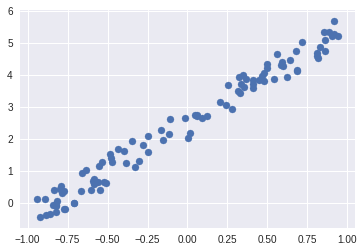

In [12]:
plt.scatter(x[:,0], y);

You want to find **parameters** (weights) `a` such that you minimize the *error* between the points and the line `x@a`. Note that here `a` is unknown. For a regression problem the most common *error function* or *loss function* is the **mean squared error**. 

誤差を最小化する重み（パラメータ）`a`を求める．損出関数は**平均2乗誤差**とする．


In [0]:
def mse(y_hat, y): return ((y_hat-y)**2).mean()

Suppose we believe `a = (-1.0,1.0)` then we can compute `y_hat` which is our *prediction* and then compute our error.


最適なaが分かっていないと仮定する．試しにa = (-1.0,1.0)の場合を考え，予測値 y_hat を計算し，誤差を計算する．


In [0]:
a = tensor(-1.,1)

In [15]:
y_hat = x@a
mse(y_hat, y)

tensor(7.6711)

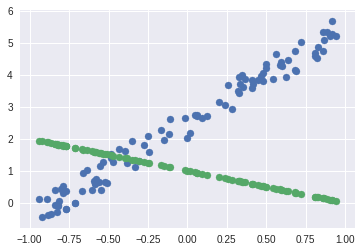

In [16]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],y_hat);

So far we have specified the *model* (linear regression) and the *evaluation criteria* (or *loss function*). Now we need to handle *optimization*; that is, how do we find the best values for `a`? How do we find the best *fitting* linear regression.

以下では最適なベクトルaを求めることを考える．

# Gradient Descent（勾配降下法）

We would like to find the values of `a` that minimize `mse_loss`.

**Gradient descent** is an algorithm that minimizes functions. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. This iterative minimization is achieved by taking steps in the negative direction of the function gradient.

Here is gradient descent implemented in [PyTorch](http://pytorch.org/).

損出関数 mse_lossを最小にするaを勾配降下法で求めよう．

PtTorchでは，変数をパラメータとよび，nnモジュールのParameterクラスで生成する．初期値として，(-1,1)を入れておく．

required_frad = True は微分値（勾配）を自動計算することを表す．

関数updateは探索の1反復を表す．

これを学習率（ステップサイズ）lr = 0.1 で100回繰り返す．


In [19]:
a = nn.Parameter(a); a

Parameter containing:
tensor([-1.,  1.], requires_grad=True)

In [0]:
def update():
    y_hat = x@a   #現在のaからy_hatを計算する．
    loss = mse(y, y_hat) #正解と予測値から，損出関数を計算する．
    if t % 10 == 0: print(loss)
    loss.backward() #逆伝播で，aを変化させたときの損出関数の変化量（勾配）を計算する．
    with torch.no_grad(): #勾配があるなら
        a.sub_(lr * a.grad) # a.grad（勾配）のle倍をaから減じる．（subはsubstractで減算，_ は引いた値を代入すること(置き換えること)を表す．
        a.grad.zero_()      # 勾配を0に戻しておく．

In [21]:
lr = 1e-1
for t in range(100): update()

tensor(7.6711, grad_fn=<MeanBackward1>)
tensor(1.4497, grad_fn=<MeanBackward1>)
tensor(0.3880, grad_fn=<MeanBackward1>)
tensor(0.1493, grad_fn=<MeanBackward1>)
tensor(0.0947, grad_fn=<MeanBackward1>)
tensor(0.0822, grad_fn=<MeanBackward1>)
tensor(0.0794, grad_fn=<MeanBackward1>)
tensor(0.0787, grad_fn=<MeanBackward1>)
tensor(0.0786, grad_fn=<MeanBackward1>)
tensor(0.0785, grad_fn=<MeanBackward1>)


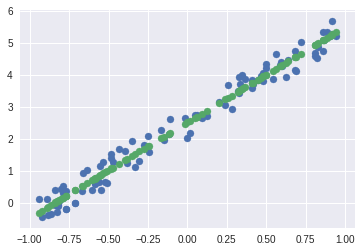

In [22]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],x@a);

## Animate it!

matplotlibにはアニメーションの機能がついている．

以下では100回の反復を，インターバル時間20で描画している．

In [0]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [24]:
a = nn.Parameter(tensor(-1.,1))

fig = plt.figure()
plt.scatter(x[:,0], y, c='orange')
line, = plt.plot(x[:,0], x@a)
plt.close()

def animate(i):
    update()
    line.set_ydata(x@a)
    return line,

animation.FuncAnimation(fig, animate, np.arange(0, 100), interval=20)

In practice, we don't calculate on the whole file at once, but we use *mini-batches*.

## Vocab（用語）

- 学習率 Learning rate
- エポック Epoch
- ミニバッチMinibatch
- 確率的勾配降下法 SGD
- モデル・アーキテキクチャ Model / Architecture
- パラメータ Parameters
- 損出関数 Loss function

分類問題においては，交差エントロピー損出関数（負対数尤度関数）を用いる．

For classification problems, we use *cross entropy loss*, also known as *negative log likelihood loss*. This penalizes incorrect confident predictions, and correct unconfident predictions.